In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import kerastuner as kt
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from sklearn import metrics

In [3]:
TrainDx = pd.read_csv('../input/prerocessed-danger-nbaiot/TrainDx.csv')
TrainDy = pd.read_csv('../input/prerocessed-danger-nbaiot/TrainDy.csv')
ValDx = pd.read_csv('../input/prerocessed-danger-nbaiot/ValDx.csv')
ValDy = pd.read_csv('../input/prerocessed-danger-nbaiot/ValDy.csv')

In [4]:
TotalTrainDx = pd.concat([TrainDx, ValDx], axis=0) 
TotalTrainDy = pd.concat([TrainDy, ValDy], axis=0)

In [5]:
def build_model3(hp):
    model = Sequential()
    counter=0
    for i in range(hp.Int('num_layers', min_value=1, max_value=5)):
        if counter == 0:
            model.add(Dense(hp.Int('units'+str(i), min_value=8, max_value=48, step=8), activation=hp.Choice('activation'+str(i), values=['relu', 'tanh', 'sigmoid']), input_dim=32))
        else:
            model.add(Dense(hp.Int('units'+str(i), min_value=8, max_value=48, step=8), activation=hp.Choice('activation'+str(i), values=['relu', 'tanh', 'sigmoid'])))
        counter += 1
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
tuner3= kt.RandomSearch(build_model3, objective='val_accuracy', max_trials=3)

In [7]:
tuner3.search(TrainDx, TrainDy, epochs=5, validation_data = (ValDx, ValDy))

Trial 3 Complete [00h 05m 12s]
val_accuracy: 0.9997697472572327

Best val_accuracy So Far: 0.9997697472572327
Total elapsed time: 00h 16m 55s


In [34]:
best_hps = tuner3.get_best_hyperparameters(num_trials=1)[0]
print("Number of layers are: " + str(best_hps.get('num_layers')))
print("Layer1 is "+best_hps.get('activation1')+" of size "+str(best_hps.get('units0')))
print("Layer2 is "+best_hps.get('activation2')+" of size "+str(best_hps.get('units1')))

Number of layers are: 2
Layer1 is sigmoid of size 32
Layer2 is relu of size 24


In [23]:
best_model = tuner3.get_best_models(num_models=1)[0]
best_model

In [18]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1873 (7.32 KB)
Trainable params: 1873 (7.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
def accFinder(X, y, treshold):
    return metrics.accuracy_score(pd.DataFrame((best_model.predict(X)>treshold).astype(int)), y)

In [70]:
accFinder(ValDx, ValDy, 0.4)

6652/6652 [==============================] - 10s 1ms/step


0.9997603777574178

## Accuracies

> Train

In [91]:
accFinder(TrainDx, TrainDy, 0.5)

15520/15520 [==============================] - 23s 1ms/step


0.9998006491989723

> Validaiton

In [90]:
accFinder(ValDx, ValDy, 0.5)

6652/6652 [==============================] - 10s 1ms/step


0.9997697747081072

> Test

In [75]:
TestDx = pd.read_csv('../input/prerocessed-danger-nbaiot/TestDx.csv')
TestDy = pd.read_csv('../input/prerocessed-danger-nbaiot/TestDy.csv')

In [89]:
accFinder(TestDx, TestDy, 0.5)

9502/9502 [==============================] - 14s 1ms/step


0.9997599079098832

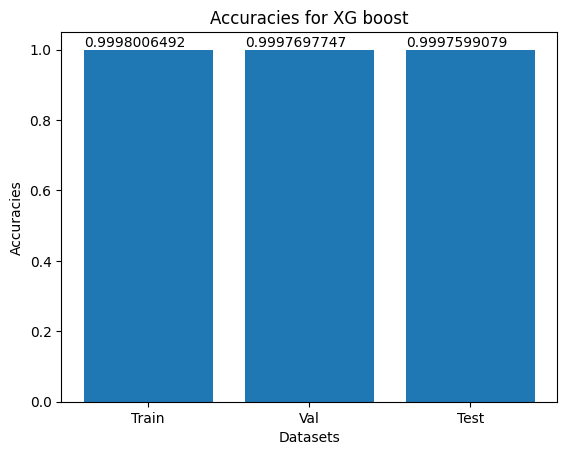

In [92]:
acc_card = [0.9998006491989723, 0.9997697747081072,0.9997599079098832]
# Create a list of indices for the x-axis
indices = range(len(acc_card))
# Create the bar graph
bars = plt.bar(indices, acc_card)
# Optionally, you can set the labels for the x-axis to be something other than the indices
labels = ['Train', 'Val', 'Test']
plt.xticks(indices, labels)
# Labeling the axes
plt.xlabel('Datasets')
plt.ylabel('Accuracies')
# Giving a title to the graph
plt.title('Accuracies for XG boost')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval, '{:.10f}'.format(yval), va='bottom') # va: vertical alignment
plt.show()

## Confusion Matrix

In [80]:
from sklearn.metrics import confusion_matrix

In [97]:
TestPreds = (best_model.predict(TestDx)>0.5).astype(int)

9502/9502 [==============================] - 14s 1ms/step


In [98]:
# 0.5
cm = pd.DataFrame(confusion_matrix(pd.DataFrame(TestPreds), TestDy, labels=[0,1]))
cm

,0,1
0,153886,50
1,23,150091


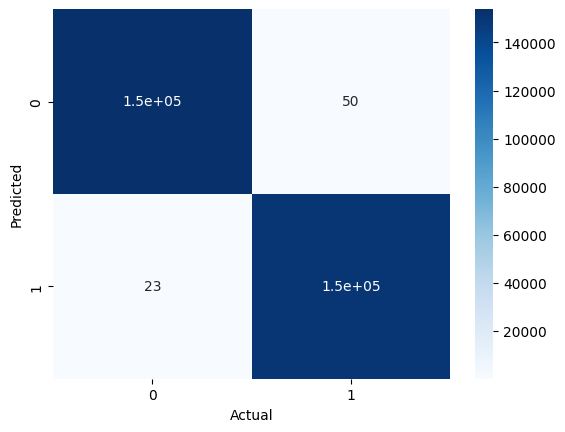

In [99]:
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Actual')
plt.ylabel('Predicted');

In [100]:
def recall(type, TestPreds, TestDy, labels):
    confMat = confusion_matrix(TestPreds, TestDy, labels=labels)
    true = confMat[type][type]
    total = 0
    for i in range(len(labels)):
        total += confMat[i][type]
    return true/total

def precision(type, TestPreds, TestDy, labels):
    confMat = confusion_matrix(TestPreds, TestDy, labels=labels)
    true = confMat[type][type]
    total = 0
    for i in range(len(labels)):
        total += confMat[type][i]
    return true/total

def specificity(type, TestPreds, TestDy, labels):
    confMat = confusion_matrix(TestPreds, TestDy, labels=labels)
    true = 0
    for i in range(len(labels)):
        if(i==type):
            continue;
        true += confMat[i][i]
    total = 0
    for j in range(len(labels)):
        if(j==type):
            continue
        for i in range(len(labels)):
            total += confMat[i][j]
    return true/total

In [101]:
labels=[0,1]

In [102]:
for i in range(len(labels)):
    print('recall of class '+str(i)+': '+str(recall(i, TestPreds, TestDy, [0,1])))

recall of class 0: 0.9998505610458128
recall of class 1: 0.9996669797057433


In [103]:
for i in range(len(labels)):
    print('precision of class '+str(i)+': '+str(precision(i, TestPreds, TestDy, [0,1])))

precision of class 0: 0.9996751896892215
precision of class 1: 0.9998467831115019


In [104]:
for i in range(len(labels)):
    print('specificity of class '+str(i)+': '+str(specificity(i, TestPreds, TestDy, [0,1])))

specificity of class 0: 0.9996669797057433
specificity of class 1: 0.9998505610458128


## Saving the model

In [105]:
import pickle
with open('ANNDanger.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [106]:
import joblib
dt = {
    'ANNDanger':best_model,
}
joblib.dump(dt, 'ANNDanger.joblib')

['ANNDanger.joblib']